In [2]:
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os

In [3]:
# Read files
# ======================
datafolder = "data"
# Read geopandas file
gdf = gpd.read_file(os.path.join(datafolder, "comunas.geojson"))

# Read 2017 census file
census_full_df = pd.read_excel(
        os.path.join(datafolder, "CENSO2017_POBLACION.xls"), sheet_name="Comuna",
        header=2, index_col="ORDEN", usecols=lambda colname: "Unnamed" not in colname,)

WARNING *** file size (9789312) not 512 + multiple of sector size (512)


In [4]:
# Prepare dataframes
# ====================
# Keep only total population in each comuna
census_df = census_full_df[census_full_df["EDAD"] == "Total Comuna"]

# Change Comuna names to upper case to do a merge
gdf["Comuna"] = gdf["Comuna"].apply(lambda x: x.upper())

# Fix name differences
gdf.loc[gdf['Comuna'] == "MARCHIGÜE", "Comuna"] = "MARCHIHUE"
gdf.loc[gdf['Comuna'] == "LOS ALAMOS", "Comuna"] = "LOS ÁLAMOS"
gdf.loc[gdf['Comuna'] == "LOS ANGELES", "Comuna"] = "LOS ÁNGELES"
gdf.loc[gdf['Comuna'] == "PAIHUANO", "Comuna"] = "PAIGUANO"
gdf.loc[gdf['Comuna'] == "RANQUIL", "Comuna"] = "RÁNQUIL"

# Remove "Zona sin demarcar" row
gdf.drop(gdf[gdf["Region"] == "Zona sin demarcar"].index, inplace=True)

# Join dataframes
gdf_census = gdf.merge(census_df, left_on='Comuna', right_on="NOMBRE COMUNA", how='left', indicator=True) 


# Calculate data of interest
# ==============================
# Population (in miles)
gdf_census["TOTAL (MILES)"] =  gdf_census["TOTAL POBLACIÓN EFECTIVAMENTE CENSADA"]/1000

# Calculate population density
gdf_census = gdf_census.to_crs({'proj':'cea'}) 
gdf_census["AREA"] = gdf_census["geometry"].area / 10**6 # In km^2
gdf_census["DENSIDAD POBLACION"] = gdf_census["TOTAL POBLACIÓN EFECTIVAMENTE CENSADA"]/gdf_census["AREA"] # 

# Calculate mean age
def calc_mean_age(name):
    filtered_df = census_full_df[
            (census_full_df["NOMBRE COMUNA"] == name)
            & census_full_df["EDAD"].apply(lambda x: "Total" not in x)]
    filtered_df.loc[filtered_df["EDAD"] == "100 o más", "EDAD"] = 100
    try:
        return np.average(filtered_df["EDAD"].astype(int), weights=filtered_df["TOTAL POBLACIÓN EFECTIVAMENTE CENSADA"])
    except ZeroDivisionError:
        return 0
gdf_census["EDAD MEDIA"] = gdf_census["Comuna"].apply(calc_mean_age)

# Calculate sex ratio (male population/female population)
gdf_census["URBANO-RURAL"] = gdf_census["TOTAL ÁREA URBANA"]/gdf_census["TOTAL POBLACIÓN EFECTIVAMENTE CENSADA"]

Text(0.5, 0.98, 'Censo Chile 2017')

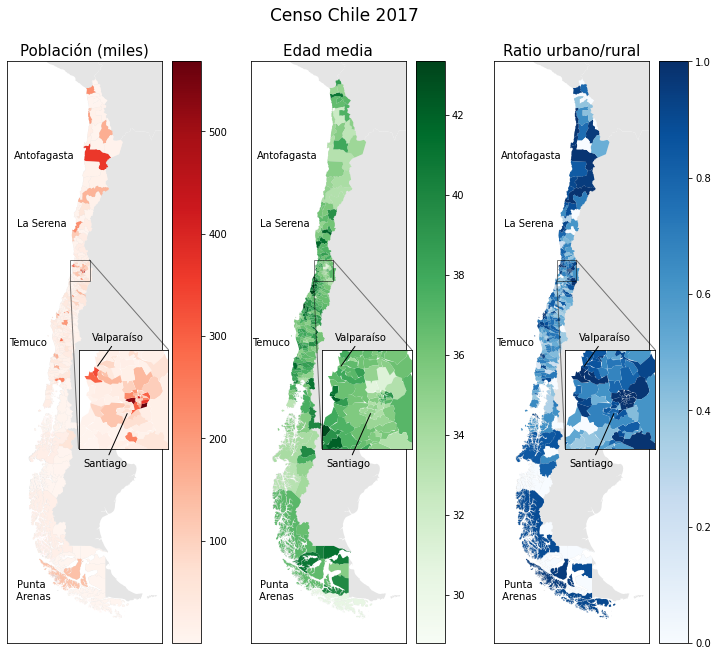

In [5]:
# Plot maps

# Parameters
xlims = (-0.865e7, -0.705e7)
ylims = (-7.8e6, -1.8e6)
fig_h = 9.5
columns = ["TOTAL (MILES)", "EDAD MEDIA", "URBANO-RURAL"]
ax_titles = ["Población (miles)", "Edad media", "Ratio urbano/rural"]
cmaps = ["Reds", "Greens", "Blues"]

fig_w = 1.05*fig_h*(np.diff(xlims)/np.diff(ylims))[0]


# Prepare maps
gdf_census = gdf_census.to_crs(epsg=900913) # Use Mercator projection
# Base world map
world = gpd.read_file(os.path.join(datafolder, "ne_10m_admin_0_countries.shp"))
world = world.to_crs(gdf_census.crs)

# Init plot
fig, axs = plt.subplots(
        ncols=3, figsize=(4*fig_w, fig_h),
        gridspec_kw=dict(hspace=0.5, top=0.9, bottom=0.05, left=0.05, right=0.95))

# Iterate over maps
axins_list = list()
for column, ax_title, cmap, ax in zip(columns, ax_titles, cmaps, axs):
    ax.set_title(ax_title, fontsize=15, ha="center")
    
    # Plot world map in the background
    world.plot(ax=ax, color='#E5E5E5', edgecolor='None', figsize=(fig_w, fig_h))
    
    # Create inset axes
    axins_xlim = (-8e6, -7.8e6)
    axins_ylim = (-4.07e6, -3.85e6)
    axins_w = 0.58
    axins_h = axins_w*(axins_ylim[1]-axins_ylim[0])/(axins_xlim[1]-axins_xlim[0])
    axins = ax.inset_axes(
        [0.46, 0.1, axins_w, axins_h], xlim=axins_xlim, ylim=axins_ylim)
    axins_list.append(axins)

    # Plot data
    for ax1 in (ax, axins):
        if ax1 == ax:
            legend_kwargs = dict(legend=True)
        else:
            legend_kwargs = dict()

        gdf_census.plot(
                ax=ax1,
                column=column,
                cmap=cmap, 
                **legend_kwargs
                )
        
    # Write city labels
    ax.text(-8.58e6, -2.8e6, "Antofagasta")
    ax.text(-8.55e6, -3.5e6, "La Serena")
    ax.text(-8.63e6, -4.73e6, "Temuco")
    ax.text(-8.4e6, -7.35e6, "Punta\n Arenas", ha="center")
    axins.annotate("Valparaíso", [-7.96e6, -3.89e6], xytext=[-7.97e6, -3.83e6], arrowprops=dict(arrowstyle="-"))
    axins.annotate("Santiago", [-7.89e6, -3.988e6], xytext=[-7.99e6, -4.11e6], arrowprops=dict(arrowstyle="-"))

    # Hide ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    axins.xaxis.set_ticks([])
    axins.yaxis.set_ticks([])

    # Set xlims
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)

    ax.indicate_inset_zoom(axins, edgecolor="black")
    
# Figure title
fig.suptitle("Censo Chile 2017", fontsize=17)

In [ ]:
fig.savefig("chile_census2017.png", dpi=350)